In [3]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
from tqdm import trange

DEVICE = 'cuda'

torch.__version__, torch.cuda.is_available()

('1.3.1', True)

In [2]:
class RNNCell(nn.Module):
    def __init__(self, in_size, out_size):
        super(RNNCell, self).__init__()
        self.h = nn.Linear(in_size + out_size, out_size)
        self.u = nn.Linear(in_size + out_size, out_size)
        self.h.weight.data.normal_(0, np.sqrt(2. / out_size))
        self.u.weight.data.normal_(0, np.sqrt(2. / out_size))

    def forward(self, x, h):
        cat = torch.cat((x, h), dim=-1)

        new = torch.tanh(self.h(cat))
        u = torch.sigmoid(self.u(cat))
        out = u * h + (1 - u) * new

        return out, out

In [3]:
cell = RNNCell(10, 20)
# cell = torch.jit.script(cell)

x = torch.rand(5, 10)
h = torch.rand(5, 20)

y, h = cell(x, h)
y.shape, h.shape, x.shape

(torch.Size([5, 20]), torch.Size([5, 20]), torch.Size([5, 10]))

In [43]:
class RNNLoop(nn.Module):
    def __init__(self, in_size, out_size):
        super(RNNLoop, self).__init__()
        self.in_size = in_size
        self.out_size = out_size

        self.cell = RNNCell(in_size, out_size)
        self.cell = torch.jit.script(self.cell)

        self.DEVICE = DEVICE
        
    def forward(self, xs):
        bs = xs.size(0)
        seq_size = xs.size(1)

        h = torch.zeros(bs, self.out_size).to(self.DEVICE)
        y = torch.zeros(bs, self.out_size).to(self.DEVICE)
        rollout = torch.zeros(bs, seq_size, self.out_size).to(self.DEVICE)

        for i in range(xs.size(1)):
            y, h = self.cell(xs[:, i], h)
            rollout[:, i] = y

        return rollout

In [44]:
def RNN(in_size, out_size):
    loop = RNNLoop(in_size, out_size)
    loop = torch.jit.script(loop)
    return loop.to(DEVICE)

In [45]:
rnn = RNN(10, 20)
print(rnn.code)

xs = torch.rand(2, 12, 10).to(DEVICE)
rnn(xs).shape

import __torch__.___torch_mangle_19
import __torch__.___torch_mangle_14
import __torch__.torch.nn.modules.linear.___torch_mangle_15
import __torch__.torch.nn.modules.linear.___torch_mangle_17
def forward(self,
    xs: Tensor) -> Tensor:
  bs = torch.size(xs, 0)
  seq_size = torch.size(xs, 1)
  _0 = torch.zeros([bs, self.out_size], dtype=None, layout=None, device=None, pin_memory=None)
  h = torch.to(_0, torch.device(self.DEVICE), None, False, False)
  _1 = torch.zeros([bs, self.out_size], dtype=None, layout=None, device=None, pin_memory=None)
  y = torch.to(_1, torch.device(self.DEVICE), None, False, False)
  _2 = torch.zeros([bs, seq_size, self.out_size], dtype=None, layout=None, device=None, pin_memory=None)
  rollout = torch.to(_2, torch.device(self.DEVICE), None, False, False)
  h0 = h
  for i in range(torch.size(xs, 1)):
    _3 = self.cell
    _4 = torch.slice(xs, 0, 0, 9223372036854775807, 1)
    cat = torch.cat([torch.select(_4, 1, i), h0], -1)
    _5 = _3.h
    _6 = _5.weight
 

torch.Size([2, 12, 20])

(torch.Size([28, 28]), torch.Size([28, 28]))

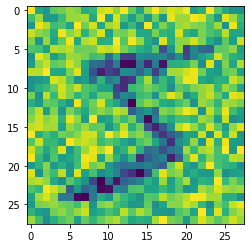

In [7]:
# Trining set
dataset = torchvision.datasets.MNIST(root='./data', download=True)
data = np.array(dataset[0][0]) / 255

X, y = torch.rand(28, 28).to(DEVICE), \
       torch.Tensor(data).to(DEVICE)

next_batch = lambda: (X.reshape(1, 28, 28), y.reshape(1, 28, 28))

plt.imshow(X.cpu().numpy() - y.cpu().numpy())
X.shape, y.shape

In [8]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, input):
        return self.lambd(input)

In [9]:
model = nn.Sequential(
    LambdaLayer(lambda x: x.reshape(1, -1, 1)),
    nn.GRU(1, 128, num_layers=2, batch_first=True),
    LambdaLayer(lambda x: x[0]),
    nn.Linear(128, 1),
    nn.Sigmoid(),
).to(DEVICE)

train = nn.Sequential(
    model,
    LambdaLayer(lambda x: x.reshape(1, 28, 28)),
)

predict = nn.Sequential(
    model,
    LambdaLayer(lambda x: x.reshape(28, 28)),
    LambdaLayer(lambda x: x.cpu().detach().numpy()),
)

sum(
    torch.prod(torch.Tensor(list((p.size()))))
    for p in model.parameters()
).item()

149505.0

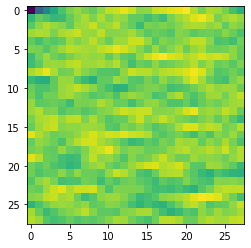

In [10]:
plt.imshow(predict(X.reshape(1, 28, 28)))

In [11]:
def fit(epochs, model, next_batch, lr=0.0005):
    history = []
    criterion = torch.nn.BCELoss().to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    t = trange(epochs)
    for i in t:
        optimizer.zero_grad()

        X, y = next_batch()
        logits = model(X)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()
        l = loss.item()

        history.append(l)
        t.set_description('Loss: %.8f' % l)
        t.refresh()

    return history

In [12]:
history = fit(100, model=train, next_batch=next_batch)

Loss: 0.40274531: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


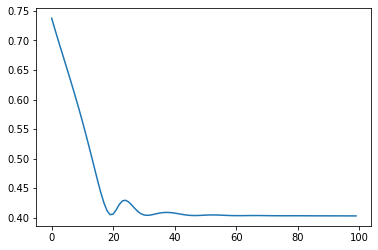

In [13]:
plt.plot(history)

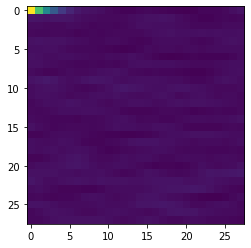

In [14]:
o = predict(X)
plt.imshow(o)

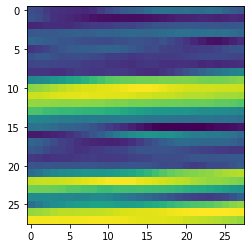

In [48]:
model = nn.Sequential(
    LambdaLayer(lambda x: x.reshape(1, -1, 1)),
    RNN(1, 256),
    nn.Linear(256, 1),
    nn.Sigmoid(),
).to(DEVICE)

train = nn.Sequential(
    model,
    LambdaLayer(lambda x: x.reshape(1, 28, 28)),
)

predict = nn.Sequential(
    model,
    LambdaLayer(lambda x: x.reshape(28, 28)),
    LambdaLayer(lambda x: x.cpu().detach().numpy()),
)

sum(
    torch.prod(torch.Tensor(list((p.size()))))
    for p in model.parameters()
).item()

o = predict(X.reshape(1, 28, 28))
plt.imshow(o)

In [55]:
history = fit(100, model=train, next_batch=next_batch)

Loss: 0.34958246: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


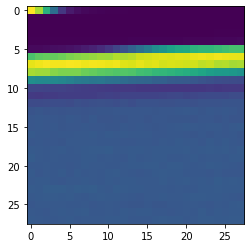

In [56]:
o = predict(X)
plt.imshow(o)

In [191]:
def seq_skip(t, skip):
    """
        Make skips in the seq dimension by moving them in the batch dimension.
        Example:
            t = torch.arange(16).reshape(4, -1)
            t
            >>  tensor([[ 0,  1,  2,  3],
                        [ 4,  5,  6,  7],
                        [ 8,  9, 10, 11],
                        [12, 13, 14, 15]])
            
            seq_skip(t, skip=2)
            >>  tensor([[ 0,  2],
                        [ 1,  3],
                        [ 4,  6],
                        [ 5,  7],
                        [ 8, 10],
                        [ 9, 11],
                        [12, 14],
                        [13, 15]])
    """
    batch_dim = 0
    seq_dim = 1

    new_shape = list(t.shape)
    new_shape[batch_dim] = new_shape[batch_dim] * skip
    new_shape[seq_dim] = -1

    return torch.cat(
        [t[:,i::skip] for i in range(skip)],
        dim=seq_dim
    ).reshape(*new_shape)


def reverse_seq_skip(skipped, skip):
    """Reverses the transformation of seq_skip"""
    batch_dim = 0
    seq_dim = 1

    old_seq_size = skipped.shape[seq_dim]
    new_shape = list(skipped.shape)
    new_batch_size = new_shape[batch_dim] // skip
    new_shape[batch_dim] = new_batch_size
    new_shape[seq_dim] = -1
    s = skipped.reshape(*new_shape)

    return torch.cat(
        [s[:,i::old_seq_size] for i in range(old_seq_size)],
        dim=seq_dim
    )


In [166]:
t = torch.rand(2, 4, 2)
t = torch.arange(32).reshape(4, -1)
t

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29, 30, 31]])

In [167]:
skip = 2

skipped = seq_skip(t, skip)

skipped

tensor([[ 0,  2,  4,  6],
        [ 1,  3,  5,  7],
        [ 8, 10, 12, 14],
        [ 9, 11, 13, 15],
        [16, 18, 20, 22],
        [17, 19, 21, 23],
        [24, 26, 28, 30],
        [25, 27, 29, 31]])

In [168]:
new_t = reverse_seq_skip(skipped, skip)
assert torch.all(t == new_t)

In [179]:
def verify(shape, skip):
    expected = torch.rand(shape)
    s = seq_skip(expected, skip)
    actual = reverse_seq_skip(s, skip)
    assert torch.all(actual == expected)

In [189]:
verify((10, 10), 2)
verify((16, 16), 4)
verify((32, 16), 8)
verify((16, 16), 16)
verify((16, 16, 10), 4)
verify((16, 16, 10), 2)
verify((16, 16, 10), 16)
print('Verified!')

Verified!


In [111]:
class DRNN(nn.Module):
    def __init__(self, cell, skip):
        self.cell = cell
        self.skip = skip

    def __forward__(self, x):
        skipped_x = torch.stack([x[i::skip] for i in range(skip)])
        skipped_y = self.cell(skipped_x)
        